In [1]:
# 1. Load and normalize 
import torch
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# Hyperparameters
num_epochs = 2 # was 6
num_classes = 2
batch_size = 4
num_workers = 3
learning_rate = 0.001

DATA_PATH_train = r"C:\Users\Dakota\Documents\ASU\Eye Tracking\data3\train"
DATA_PATH_test = r'C:\Users\Dakota\Documents\ASU\Eye Tracking\data3\test'
MODEL_STORE_PATH = r'C:\Users\Dakota\Documents\ASU\Eye Tracking/'

In [3]:


transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), 
                                                     (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.ImageFolder(root=DATA_PATH_train,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True,num_workers=num_workers)

testset = torchvision.datasets.ImageFolder(root=DATA_PATH_test,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=True,num_workers=num_workers)

classes=('left', 'right')

In [4]:
#Show some images in dataset
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))




right  left  left right


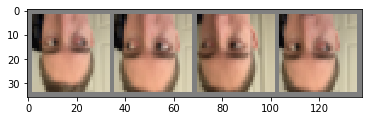

In [5]:
# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
# 2. Define CNN
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
# 4. Train Network
#net = Net().to(device) # for GPU
net = Net()
#net.to(device)

# 3. Define Loss function and Optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        #inputs, labels = inputs.to(device), labels.to(device) # for GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 1.048
[1,    20] loss: 0.525
[1,    30] loss: 0.358
[1,    40] loss: 0.383
[1,    50] loss: 0.323
[1,    60] loss: 0.270
[1,    70] loss: 0.270
[1,    80] loss: 0.147
[1,    90] loss: 0.040
[1,   100] loss: 0.011
[1,   110] loss: 0.017
[1,   120] loss: 0.155
[1,   130] loss: 0.009
[1,   140] loss: 0.027
[1,   150] loss: 0.035
[1,   160] loss: 0.008
[1,   170] loss: 0.003
[2,    10] loss: 0.034
[2,    20] loss: 0.021
[2,    30] loss: 0.017
[2,    40] loss: 0.016
[2,    50] loss: 0.025
[2,    60] loss: 0.051
[2,    70] loss: 0.030
[2,    80] loss: 0.005
[2,    90] loss: 0.034
[2,   100] loss: 0.003
[2,   110] loss: 0.007
[2,   120] loss: 0.005
[2,   130] loss: 0.002
[2,   140] loss: 0.002
[2,   150] loss: 0.000
[2,   160] loss: 0.001
[2,   170] loss: 0.000
Finished Training


GroundTruth:   left right right right


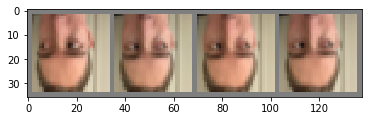

In [15]:
# 5. Test Network
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   left right right right


In [17]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 130 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 130 test images: 86 %


In [19]:
# Save the model and plot
torch.save(net.state_dict(), MODEL_STORE_PATH + 'EyeTracking_L-R.ckpt')